In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in words
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build mapping and character vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
# print(itos)

In [4]:
# build the dataset

block_size = 3 # context length: i.e. how many characters to predict the next one?
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size # context is a list of 0s of length block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), ' -----> ', itos[ix])

        context = context[1:] + [ix] # update context with the next character

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape


torch.Size([228146, 3])

In [5]:
C = torch.randn((27, 2))
C[5] # indexing row 5
C[[5, 6, 7]] # indexing rows 5, 6, 7
C[torch.tensor([5, 6, 7])] # same as above but this time using a tensor
C[X] # indexing rows of C using the indices in X


tensor([[[-1.6102,  0.3667],
         [-1.6102,  0.3667],
         [-1.6102,  0.3667]],

        [[-1.6102,  0.3667],
         [-1.6102,  0.3667],
         [ 2.2073,  0.9240]],

        [[-1.6102,  0.3667],
         [ 2.2073,  0.9240],
         [ 0.2593, -0.2932]],

        ...,

        [[-0.0641,  0.3928],
         [-0.0641,  0.3928],
         [ 1.4824,  0.6780]],

        [[-0.0641,  0.3928],
         [ 1.4824,  0.6780],
         [-0.0641,  0.3928]],

        [[ 1.4824,  0.6780],
         [-0.0641,  0.3928],
         [ 0.3473, -1.6163]]])

In [6]:
emb = C[X] # embed the input
emb.shape
emb

tensor([[[-1.6102,  0.3667],
         [-1.6102,  0.3667],
         [-1.6102,  0.3667]],

        [[-1.6102,  0.3667],
         [-1.6102,  0.3667],
         [ 2.2073,  0.9240]],

        [[-1.6102,  0.3667],
         [ 2.2073,  0.9240],
         [ 0.2593, -0.2932]],

        ...,

        [[-0.0641,  0.3928],
         [-0.0641,  0.3928],
         [ 1.4824,  0.6780]],

        [[-0.0641,  0.3928],
         [ 1.4824,  0.6780],
         [-0.0641,  0.3928]],

        [[ 1.4824,  0.6780],
         [-0.0641,  0.3928],
         [ 0.3473, -1.6163]]])

In [7]:
# inputs to NN 
w1 = torch.randn((6,100))
b1 = torch.randn((100))

h = torch.tanh((emb.view(-1, 6)) @ w1 + b1) # 
h


tensor([[ 0.8530, -0.9996, -0.9293,  ..., -0.9996, -0.6797,  0.9989],
        [ 0.9986, -0.5232, -0.0318,  ..., -0.9990,  0.9991, -0.2999],
        [ 0.9997,  0.8664, -0.8454,  ...,  0.9283,  0.7959,  0.9996],
        ...,
        [ 0.9904,  0.0128, -0.1044,  ..., -0.8648,  0.9884, -0.3192],
        [ 0.9857,  0.1721, -0.7673,  ...,  0.2249,  0.7391,  0.9843],
        [ 0.6227, -0.9964, -0.2612,  ...,  0.9978, -0.8993, -0.8503]])

Now to make more respectable

In [8]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [9]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
w1 = torch.randn((6,100), generator = g)
b1 = torch.randn((100), generator = g)
w2 = torch.randn((100,27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, w1, b1, w2, b2]

In [10]:
s = sum(p.nelement() for p in parameters)
print(s)

3481


In [16]:
emb = C[X] # embed the input as a tensor of shape 32, 3, 2
# emb.shape
h = torch.tanh((emb.view(-1, 6)) @ w1 + b1) ## tanh is making values betweeen -1 and 1
logits = h @ w2 + b2

# this is the same as a cross_entropy loss
# you wouldn't use these because its slow in terms of memory and inefficient for
# backward pass. Also can fail if logits have large numbers
# exp(big number) = infinity

# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

# F.cross_entropy(logits, Y)
# loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [12]:
for p in parameters:
    p.requires_grad_ = True

In [15]:
# training NN
for i in range(100):
    # forward pass
    emb = C[X] # embed the input as a tensor of shape 32, 3, 2
    h = torch.tanh((emb.view(-1, 6)) @ w1 + b1) ## tanh is making values betweeen -1 and 1
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:
        p.requires_grad = True
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad
    
    print(loss.item())

    # you can see that if you change the training batch size to be all data values then 
    # it takes longer to train the model. 
    # Instead you want to train on small batches

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
# Instead you can run with mini batches
for i in range(1000):

    # build minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # embed the input as a tensor of shape 32, 3, 2
    h = torch.tanh((emb.view(-1, 6)) @ w1 + b1) ## tanh is making values betweeen -1 and 1
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.requires_grad = True
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad
    
print(loss.item())

2.620084524154663


In [18]:
# how to choose the best learning rate
lre = torch.linspace(-3,1,1000)
lrs = 10**lre

lri = []
lossi = []

for i in range(1000):

    # build minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # embed the input as a tensor of shape 32, 3, 2
    h = torch.tanh((emb.view(-1, 6)) @ w1 + b1) ## tanh is making values betweeen -1 and 1
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.requires_grad = True
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    # lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track statistics
    lri.append(lre[i])
    lossi.append(loss.item())
    
print(loss.item())

70.62447357177734


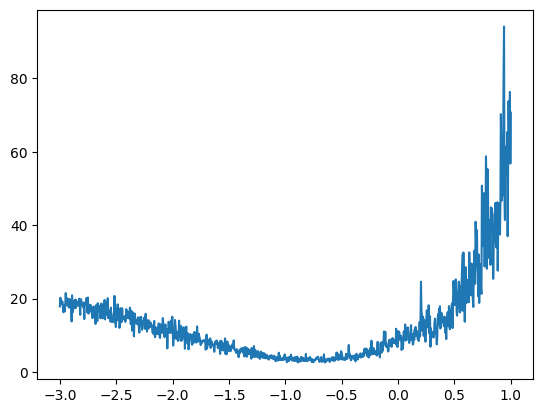

In [19]:
plt.plot(lri, lossi)


In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
w1 = torch.randn((6,300), generator = g)
b1 = torch.randn((300), generator = g)
w2 = torch.randn((300,27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, w1, b1, w2, b2]
print('Number parameters is:', sum(p.nelement() for p in parameters))

Number parameters is: 10281


In [ ]:
for p in parameters:
    p.requires_grad_ = True

In [ ]:
# Now building the model based on a split of train/dev/test

# build the dataset
def build_dataset(words, block_size):

# context length: i.e. how many characters to predict the next one?
    X, Y = [], []
    for w in words:

        context = [0] * block_size # context is a list of 0s of length block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # update context with the next character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# build the model
Xtr, Ytr = build_dataset(words[:n1], 3)
Xdev, Ydev = build_dataset(words[n1:n2], 3)
Xte, Yte = build_dataset(words[n2:], 3)

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [ ]:
# rewriting function to train the model

def train_model(X, Y, iterations):
    for i in range(iterations):

        # build minibatch
        ix = torch.randint(0, X.shape[0], (32,))

        # forward pass
        emb = C[X[ix]] # embed the input as a tensor of shape 32, 3, 2
        h = torch.tanh((emb.view(-1, 6)) @ w1 + b1) ## tanh is making values betweeen -1 and 1
        logits = h @ w2 + b2
        loss = F.cross_entropy(logits, Y[ix])

        # backward pass
        for p in parameters:
            p.requires_grad = True
            p.grad = None
        loss.backward()

        # update
        # lr = lrs[i]
        lr = 0.1
        for p in parameters:
            p.data -= lr * p.grad

        # track statistics
        # lri.append(lre[i])
        # lossi.append(loss.item())
        
    return loss.item()

def eval_model(X, Y):

        emb = C[X] # embed the input as a tensor of shape 32, 3, 2
        h = torch.tanh((emb.view(-1, 6)) @ w1 + b1) ## tanh is making values betweeen -1 and 1
        logits = h @ w2 + b2
        loss = F.cross_entropy(logits, Y)
        
        return loss.item()


def name_maker():
     
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh((emb.view(1, -1) @ w1 + b1))
        logits = h @ w2 + b2
        p = F.softmax(logits, 1)
        ix = torch.multinomial(p, 1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0: # end of name
            break
        
    return ''.join(itos[i] for i in out[:-1])

In [ ]:
lre = torch.linspace(-3,1,1000)
lrs = 10**lre

lri = []
lossi = []

for p in parameters:
    p.requires_grad_ = True


In [ ]:
# Train model on training data abd evaluate on dev data
train, test = [], []

for i in range(10):
    train.append(train_model(Xtr, Ytr, 10000))
    test.append(eval_model(Xdev, Ydev))
    print('Train:', train[-1], 'Dev:', test[-1])

Train: 2.3254358768463135 Dev: 2.5144500732421875
Train: 2.505774974822998 Dev: 2.4770965576171875
Train: 2.1773414611816406 Dev: 2.5092945098876953
Train: 2.552492380142212 Dev: 2.399718761444092
Train: 2.8685381412506104 Dev: 2.4033470153808594
Train: 1.86417555809021 Dev: 2.386216878890991
Train: 2.7555198669433594 Dev: 2.374272108078003
Train: 2.122741937637329 Dev: 2.4598124027252197
Train: 2.355531930923462 Dev: 2.4457809925079346


KeyboardInterrupt: 

Can change hyperparamters (e.g. feed in parameters, layers in MLP, batch size ) to optimise Xdev

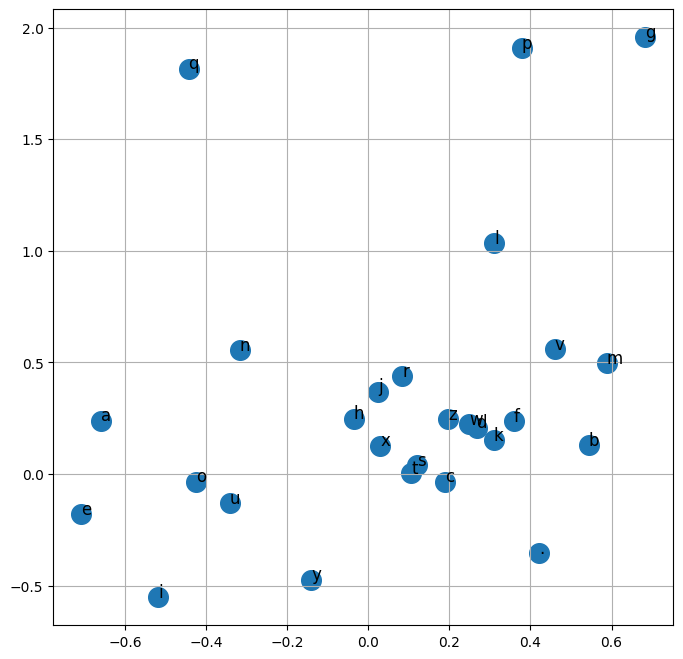

In [ ]:
# visualise dimensions of embeddings

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
 
for i in range(C.shape[0]):
    plt.text(C[i,0], C[i,1], itos[i], fontsize=12)

plt.grid('minor')
plt.show()


In [ ]:
#printing names 
for i in range(10):
    print(name_maker())

zohlelea
matel
lex
mena
vale
desha
yven
ayre
orharolene
thana
